In [1]:
################ Library imports ################
import numpy as np
import math as math
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import scipy.linalg
import seaborn as sns
import time

import itertools

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel

from sklearn.metrics import mean_squared_error, mean_absolute_error

from scipy.optimize import curve_fit

from IPython.display import display, Markdown, clear_output
import ipywidgets as widgets

In [2]:
"""
Locations plot
"""
locations = np.array(np.meshgrid(np.linspace(0, 8, 9), np.linspace(0, 8, 9))).T.reshape(-1, 2)

# ----------------------------------------------------------------------
#  AP locations
L_ap = locations[[0,4,8,36,40,44,72,76,80], :]

# ----------------------------------------------------------------------
#  VRP locations
L_vrp = np.delete(locations, [0,4,8,36,40,44,72,76,80], 0)

In [3]:
"""
Compute Euclidean distance vector
    
    target --> Reference AP location to calculate distance
    array --> Array of AP/VRP locations
"""
def compute_euclidean_distance_vector(target, array):
    d_vec = np.array([np.linalg.norm(target - i) for (i) in array])
    return d_vec

In [4]:
"""
Polynomial Surface model fitting
    
    loc --> X,Y tuple array of AP locations
    d --> AP RTT distance observations
    order --> Polinomial order
"""
def surface_fit(loc, d, order=1):
    if order == 1:
        A = np.c_[loc[:,0], loc[:,1], np.ones(loc.shape[0])]
        C,_,_,_ = scipy.linalg.lstsq(A, d)
    else:
        A = np.c_[np.ones(loc.shape[0]), loc[:,:2], np.prod(loc[:,:2], axis=1), loc[:,:2]**2]
        C,_,_,_ = scipy.linalg.lstsq(A, d)
    return C

In [5]:
"""
RTT distance estimation
    
    x --> AP's x locations
    y --> AP's y locations
    C --> Model coefficients
"""
def sample_distance(x, y, C):
    
    XX = x.flatten()
    YY = y.flatten()
    
    if C.shape[0] == 3:
        fit = np.dot(np.c_[XX, YY, np.ones(XX.shape)], C).reshape(x.shape)
    else:
        fit = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX*YY, XX**2, YY**2], C).reshape(x.shape)
    return fit

In [6]:
"""
Target AP to compute algorithm: AP[0,0]

Let's assume an euclidean distance as RTT distance observations
""" 
d_RTT = compute_euclidean_distance_vector(L_ap[0], L_ap)

In [7]:
"""
Surface fitting models
"""

# Plot domain
X,Y = np.meshgrid(np.arange(0.0, 9.0, 1), np.arange(0.0, 9.0, 1))

#Model fitting and surface estimation
model_1 = surface_fit(L_ap, d_RTT)
model_2 = surface_fit(L_ap, d_RTT, 2)

Z_1 = sample_distance(X, Y, model_1)
Z_2 = sample_distance(X, Y, model_2)

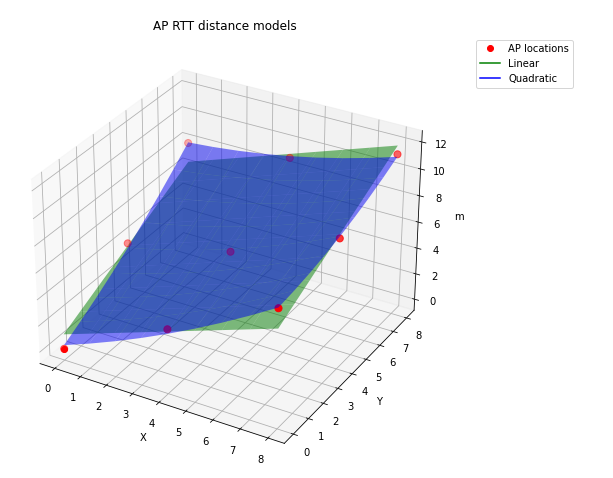

In [8]:
"""
Surface fitting plot
"""
fig = plt.figure(figsize=(12,8))

ax = fig.gca(projection='3d')

l1 = ax.plot_surface(X, Y, Z_1, rstride=1, cstride=1, alpha=0.5, label='linear', color='g')
l2 = ax.plot_surface(X, Y, Z_2, rstride=1, cstride=1, alpha=0.5, label='quadratic', color='b')

ax.scatter(L_ap[:,0], L_ap[:,1], d_RTT, c='r', s=50)

plt.xlabel('X')
plt.ylabel('Y')
ax.set_zlabel('m')
ax.axis('auto')

line_labels = ["AP locations","Linear", "Quadratic"]

ax.plot([0], [0], color="red", marker='o', linewidth=0)[0]
ax.plot([0], [0], color="green")[0]
ax.plot([0], [0], color="blue")[0]

fig.legend(labels=line_labels,loc="upper right",borderaxespad=4)

plt.title('AP RTT distance models')
plt.show()

In [9]:
"""
Mean RTT distance values at VRPs
    _1 --> Order 1 surface fit
    _2 --> Order 2 surface fit
"""

fit_1 = np.reshape(Z_1, (81,1))
fit_2 = np.reshape(Z_2, (81,1))

# ----------------------------------------------------------------------
#  Mean RTT observations between target AP and the rest
m_ap_1 = fit_1[[0,4,8,36,40,44,72,76,80], :]
m_ap_2 = fit_2[[0,4,8,36,40,44,72,76,80], :]

# ----------------------------------------------------------------------
#  Mean RTT observations between target AP and VRPs
m_vrp_1 = np.delete(fit_1, [0,4,8,36,40,44,72,76,80], 0)
m_vrp_2 = np.delete(fit_2, [0,4,8,36,40,44,72,76,80], 0)

In [10]:
"""
Gaussian Process Kernel definition

Kernel parameters:
    - L --> Length Scale
    - sigma_f --> Constant Kernel Amplitude
"""

l = 2.47
sigma_f = 4

kernel = ConstantKernel(constant_value=sigma_f,constant_value_bounds=(1e-3, 1e3)) \
            * RBF(length_scale=l, length_scale_bounds=(1e-3, 1e3))  

In [11]:
"""
Gaussian Process Regressor definition

- sigma_n --> Training Noise Variance
"""

# Error standard deviation. 
sigma_n = 0

gp = GaussianProcessRegressor(kernel=kernel, alpha=sigma_n**2, n_restarts_optimizer=10)

In [12]:
"""
Model Fitting with AP location and RTT distance observations
using Maximum Likelihood Estimation of the parameters.
"""

gp.fit(L_ap, d_RTT)

GaussianProcessRegressor(alpha=0, kernel=2**2 * RBF(length_scale=2.47),
                         n_restarts_optimizer=10)

In [13]:
y_pred, sigma = gp.predict(L_vrp, return_cov=True)
print(y_pred)

[ 0.55000376  1.40819426  2.57916887  5.51426496  6.87138072  7.77809979
  0.55000376  1.04975571  1.81844431  2.89603137  4.25394649  5.7531228
  7.13643827  8.08575407  8.33739156  1.40819426  1.81844431  2.42057307
  3.30279461  4.48785096  5.87034769  7.19964021  8.14141286  8.40640626
  2.57916887  2.89603137  3.30279461  3.94453995  4.90593128  6.1239784
  7.35945178  8.26321182  8.5195221   4.25394649  4.48785096  4.90593128
  6.71992042  7.86428588  8.72115551  5.51426496  5.7531228   5.87034769
  6.1239784   6.71992042  7.67261351  8.75287084  9.56685939  9.73527871
  6.87138072  7.13643827  7.19964021  7.35945178  7.86428588  8.75287084
  9.79325484 10.567933   10.66933219  7.77809979  8.08575407  8.14141286
  8.26321182  8.72115551  9.56685939 10.567933   11.29617362 11.33136697
  8.33739156  8.40640626  8.5195221   9.73527871 10.66933219 11.33136697]


In [14]:
opt_l = gp.kernel_.get_params().get('k1__k2__length_scale')
opt_sigma_f = gp.kernel_.get_params().get('k1__k1__constant_value')
print(opt_l)
print(opt_sigma_f)

None
None


In [20]:
diff = np.diag(d_RTT - m_ap_1)
print(diff)

[-1.12057393  0.16976267  1.46009927  0.16976267 -0.88304648 -0.30529222
  1.46009927 -0.30529222 -0.64551903]


In [16]:
gp.fit(L_ap, diff)

GaussianProcessRegressor(alpha=0, kernel=2**2 * RBF(length_scale=2.47),
                         n_restarts_optimizer=10)

In [17]:
y_pred, sigma = gp.predict(L_vrp, return_cov=True)
s_var = np.diag(sigma)
print(y_pred)
print(s_var)

[-0.95610908 -0.66695984 -0.27725805  0.6188896   1.0128746   1.3033113
 -0.95610908 -0.89806773 -0.736991   -0.47663587 -0.13929046  0.23572678
  0.5983373   0.89798306  1.0953109  -0.66695984 -0.736991   -0.73730091
 -0.64697835 -0.46175946 -0.19942704  0.10163686  0.39140179  0.62187205
 -0.27725805 -0.47663587 -0.64697835 -0.74201274 -0.7291551  -0.60211637
 -0.38474172 -0.12392088  0.12560727 -0.13929046 -0.46175946 -0.7291551
 -0.89411955 -0.77098636 -0.55520856  0.6188896   0.23572678 -0.19942704
 -0.60211637 -0.89411955 -1.02731624 -0.99646689 -0.83631225 -0.60557594
  1.0128746   0.5983373   0.10163686 -0.38474172 -0.77098636 -0.99646689
 -1.04504584 -0.94398033 -0.7487355   1.3033113   0.89798306  0.39140179
 -0.12392088 -0.55520856 -0.83631225 -0.94398033 -0.89814011 -0.74819137
  1.0953109   0.62187205  0.12560727 -0.60557594 -0.7487355  -0.74819137]
[0.01681297 0.02698634 0.01194271 0.01194271 0.02698634 0.01681297
 0.01681297 0.03340471 0.04344422 0.02859854 0.01681297 0.

In [18]:
res = np.diag(m_vrp_1 + y_pred)

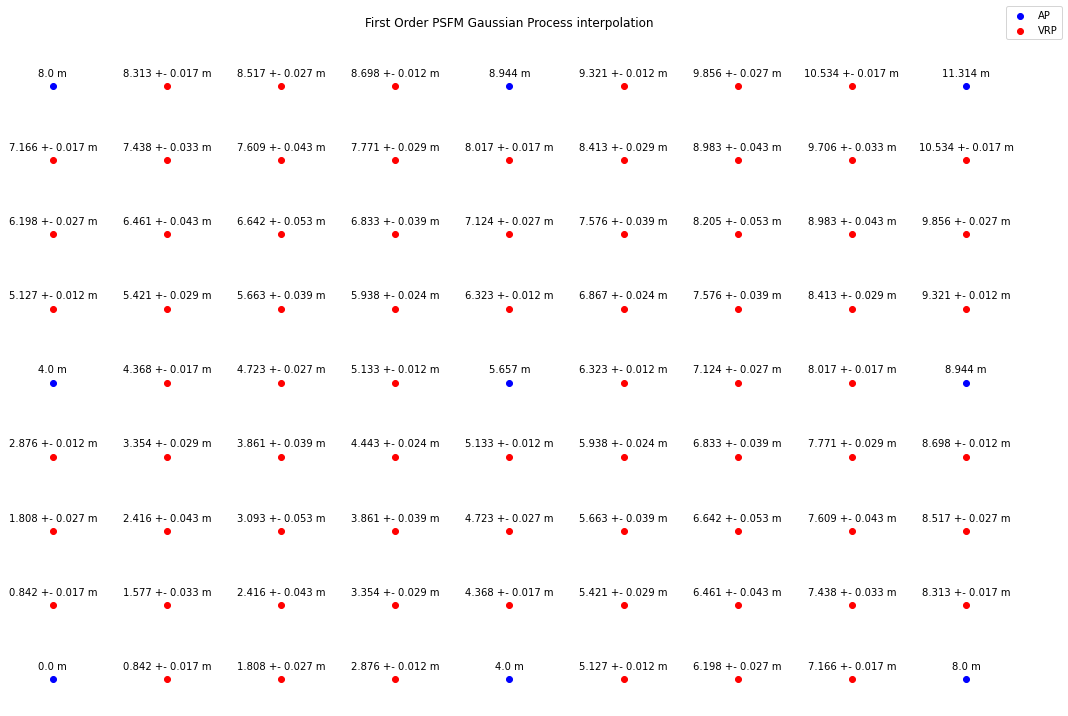

In [19]:
"""
First Order PSFM Gaussian Process interpolation:
    
    s_bar_star --> Mean estimated value for each VRP
    cov_s_star --> Posterior covariance matrix
    var_s_star --> VRP estimation variance
"""
plt.figure(figsize=(18,12))

plt.scatter(L_ap[:,0], L_ap[:,1], c='b')
plt.scatter(L_vrp[:,0], L_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-5)
plt.title('First Order PSFM Gaussian Process interpolation',pad=30)
plt.axis('off')

for x in range(len(d_RTT)):
    label = f"{d_RTT[x].round(3)} m"

    plt.annotate(label, # this is the text
                 (L_ap[x,0],L_ap[x,1]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x in range(len(res)):
    label = f"{res[x].round(3)} +- {s_var[x].round(3)} m"

    plt.annotate(label, # this is the text
                 (L_vrp[x,0],L_vrp[x,1]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center